# Bayesian Bandits Explanation

### `Exploration` and `Exploitation` play a key role in any business.   
And any good business will try to “explore” various opportunities where it can make a profit.

## Problem to Solve:
Assume that we have infinite slot machines. Every slot machine has some win probability. But we don’t know these probability values. You have to operate these slot machines one by one.    
**How do you come up with a strategy to maximize your outcome from these slot machines in minimum time.**

You will most probably start by trying out some machines.
Would you stick to a particular machine that has an okayish probability(exploitation) or would you keep searching for better machines(exploration)?
It is the exploration-exploitation tradeoff.
And the question is how do we balance this tradeoff such that we get maximum profits?
### The answer is `Bayesian Bandits`.

## Business Use-cases:
There are a lot of places where such a thought experiment could fit.

* AB Testing: You have a variety of assets that you can show at the website. Each asset has a particular probability of success(getting clicked by the user). 
* Ad Clicks: You have a variety of ads that you can show to the user. Each advert has a particular probability of clickthrough.
* Finance: which stock pick gives the highest return.
* We as human beings are faced with the exact same problem — Explore or exploit and we handle it quite brilliantly mostly. Should we go find a new job or should we earn money doing the thing we know would give us money? 

In this notebook, we will focus on AB Testing but this experiment will work for any of the above problems.   
## Problem Statement:
The problem we have is that we have different assets which we want to show on our awesome website but we really don’t know which one to show.   
One asset is blue(B), another red(R) and the third one green(G). Our UX team say they like the blue one. But you like the green one. Which one to show on our website?

Let's revisit following knowledge:  
##### Bayes Theorem
##### Beta Distribution
##### Bayesian Bandits

For the sake of this problem, let's assume that we know the click probabilities of these assets also.   
The win probability of red(R) is 0.7, green(G) is 0.5 and blue(B) is 0.3. Please note that in real life, we won’t know this.   
These probabilities are going to be hidden from our algorithm and we will see how our algorithm will still converge to these real probabilities.  
**So, what are our priors(beliefs) about the probability of each of these assets?**

Since we have not observed any data we cannot have prior beliefs about any of our three assets.   
We need to model our prior probabilities and we will use beta distribution to do that. See the curve for beta distribution above for α = 1 and β=1.   
`Beta(1,1)` is actually just a `uniform distribution` over the range [0,1]. And that is what we want for our prior probabilities for our assets. We don’t have any information yet so we start with a uniform probability distribution over our probability values.   
**So we can denote the prior probabilities of each of our asset using a beta distribution.**

## Strategy:
* We will sample a random variable from each of the 3 distributions for assets.
* We will find out which random variable is maximum and will show the one asset which gave the maximum random variable.
* We will get to know if that asset is clicked or not.
* We will update the prior for the asset using the information in previous step.
* Repeat.

## Updating the Prior:
The reason we took beta distribution to model our probabilities is because of its great mathematical properties.   
If the prior is f(α,β), then the posterior distribution is again beta, given by f(α+#success, β+#failures)   
where #success is the number of clicks and #failures are the number of views minus the number of clicks.

# Code Simulation

In [16]:
import numpy as np 
import pandas as pd 
import scipy

%matplotlib inline
import numpy as np
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt
import scipy.stats as stats
import matplotlib
import matplotlib.animation as animation
import seaborn as sns

In [17]:
real_probs_dict = {'red':0.7,'green':0.5,'blue':0.3}
assets = ['red','green','blue']

In [18]:
'''
This function takes as input three tuples for alpha,beta that specify priorR,priorG,priorB 
And returns R,G,B along with the maximum value sampled from these three distributions.
We can sample from a beta distribution using 
'''

def find_asset(priorR,priorG,priorB):    
    red_rv = stats.beta.rvs(priorR[0],priorR[1])
    green_rv = stats.beta.rvs(priorG[0],priorG[1])
    blue_rv = stats.beta.rvs(priorB[0],priorB[1])
    return assets[np.argmax([red_rv,green_rv,blue_rv])]
    
'''
This is a helper function that simulates the real world using the actual probability value of the assets.
In real life we won't have this function and our user click input will be the proxy for this function.
'''

def simulate_real_website(asset, real_probs_dict):
    #simulate a coin toss with probability. Asset clicked or not.
    if real_probs_dict[asset]> scipy.stats.uniform.rvs(0,1):
        return 1
    else:
        return 0

'''
This function takes as input the selected asset and returns the updated posteriors for the selected asset.
'''
def update_posterior(asset,priorR,priorG,priorB,outcome):
    if asset=='red':
        priorR=(priorR[0]+outcome,priorR[1]+1-outcome)
    elif asset=='green':
        priorG=(priorG[0]+outcome,priorG[1]+1-outcome)
    elif asset=='blue':
        priorB=(priorB[0]+outcome,priorB[1]+1-outcome)
    return priorR,priorG,priorB

'''
This function runs the strategy once.
'''
def run_strategy_once(priorR,priorG,priorB):
    # 1. get the asset
    asset = find_asset(priorR,priorG,priorB)
    # 2. get the outcome from the website
    outcome = simulate_real_website(asset, real_probs_dict)
    # 3. update posterior
    priorR,priorG,priorB = update_posterior(asset,priorR,priorG,priorB,outcome)
    return asset,priorR,priorG,priorB

In [19]:
priorR,priorG,priorB = (1,1),(1,1),(1,1) # assume all beta(1,1) at beginning
data = [("_",priorR,priorG,priorB)]
n_trails = 160
for i in range(n_trails):
    asset,priorR,priorG,priorB = run_strategy_once(priorR,priorG,priorB)
    data.append((asset,priorR,priorG,priorB))

In [20]:
def plot_posteriors(priorR,priorG,priorB,n,ax=None,title=None):
    #fig = plt.figure(figsize=(12.5, 10))
    parameters = [priorR,priorG,priorB]
    x = np.linspace(0.001, 1, n)
    for i, (alpha, beta) in enumerate(parameters):
        color = assets[i]
        y = stats.beta.pdf(x, alpha, beta)
        lines = sns.lineplot(x, y, label="%s (%.1f,%.1f)" % (color, alpha, beta), color = color,ax=ax)
        plt.fill_between(x, 0, y, alpha=0.2, color=color)
        if title:
            plt.title(title)
        plt.autoscale(tight=True)
    plt.legend(title=r"$\alpha, \beta$ - parameters")
    return plt

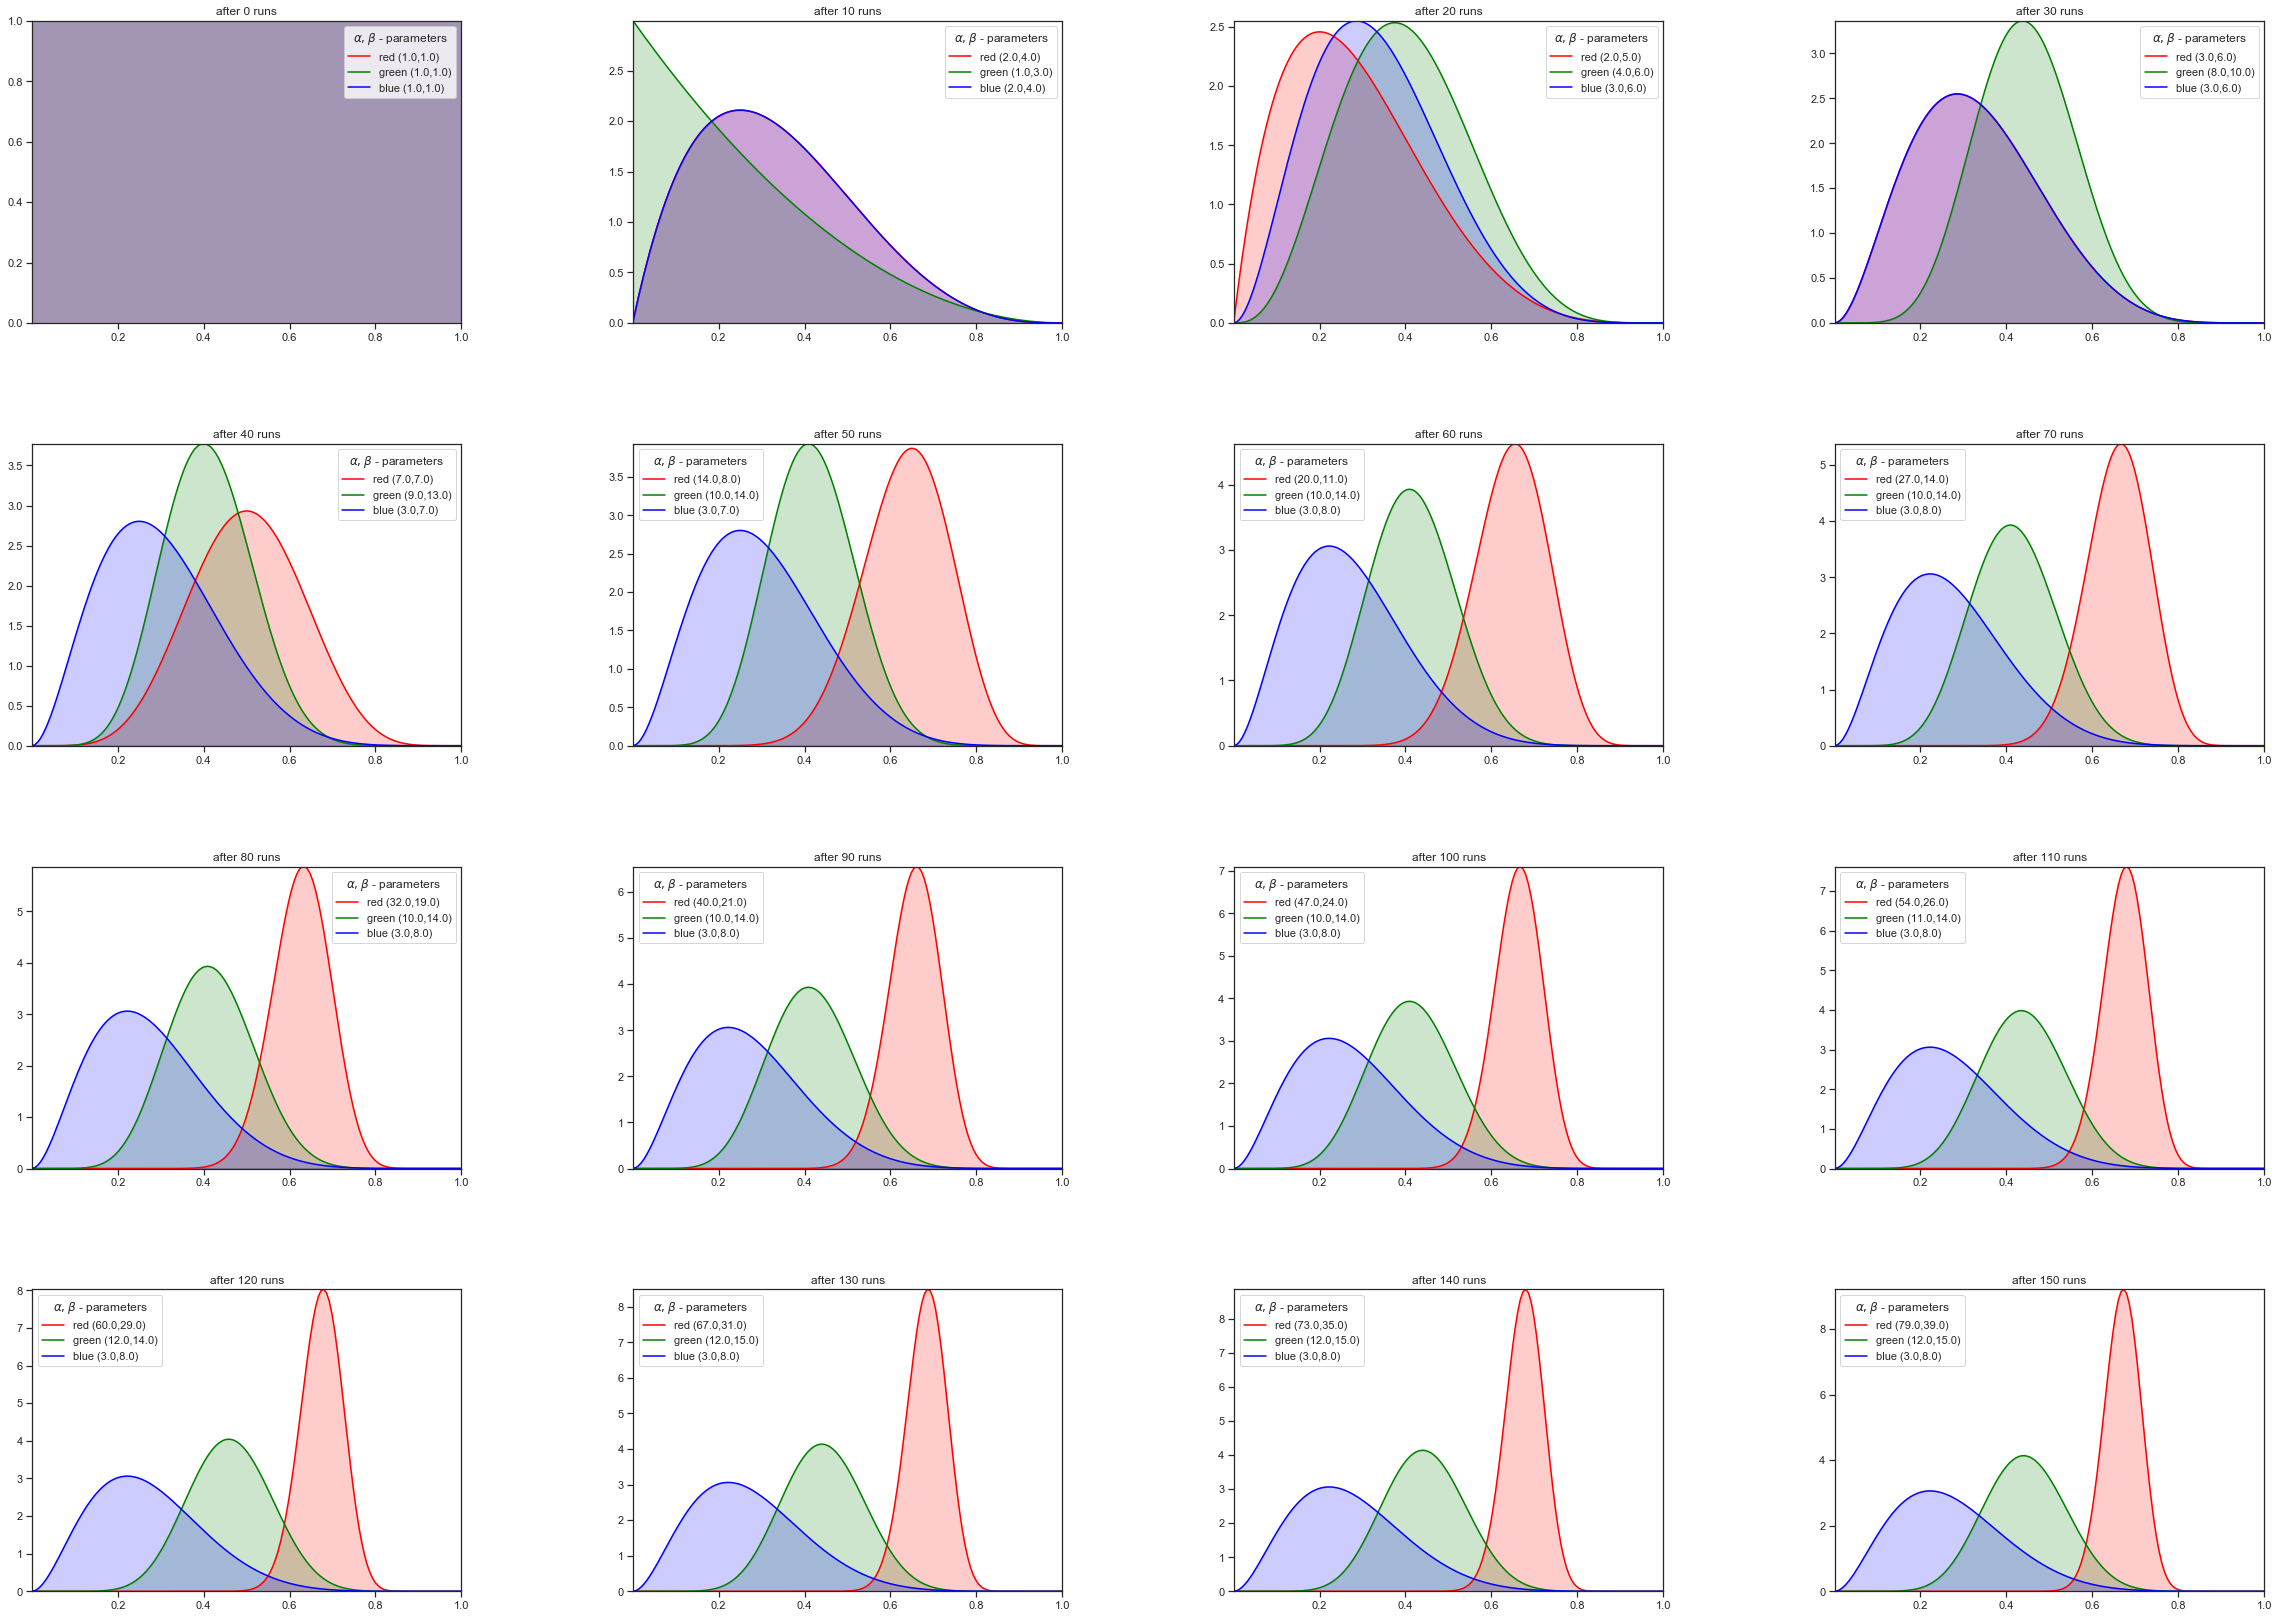

In [21]:
fig = plt.figure(figsize=(40, 60))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
cnt=1
for i in range(0,n_trails,int(n_trails/15)):
    ax = fig.add_subplot(8, 4, cnt)
    g = plot_posteriors(*data[i][1:],n_trails,ax,"after "+str(i)+" runs")
    cnt+=1
plt.show()

In [22]:
for i,x in enumerate(data[1:]):
    print("Pick",i+1,":",x[0],end=" ,")

Pick 1 : blue ,Pick 2 : red ,Pick 3 : green ,Pick 4 : green ,Pick 5 : red ,Pick 6 : red ,Pick 7 : blue ,Pick 8 : red ,Pick 9 : blue ,Pick 10 : blue ,Pick 11 : red ,Pick 12 : green ,Pick 13 : green ,Pick 14 : blue ,Pick 15 : green ,Pick 16 : green ,Pick 17 : green ,Pick 18 : blue ,Pick 19 : blue ,Pick 20 : green ,Pick 21 : green ,Pick 22 : green ,Pick 23 : red ,Pick 24 : green ,Pick 25 : green ,Pick 26 : green ,Pick 27 : red ,Pick 28 : green ,Pick 29 : green ,Pick 30 : green ,Pick 31 : red ,Pick 32 : green ,Pick 33 : red ,Pick 34 : red ,Pick 35 : green ,Pick 36 : blue ,Pick 37 : green ,Pick 38 : red ,Pick 39 : red ,Pick 40 : green ,Pick 41 : green ,Pick 42 : green ,Pick 43 : red ,Pick 44 : red ,Pick 45 : red ,Pick 46 : red ,Pick 47 : red ,Pick 48 : red ,Pick 49 : red ,Pick 50 : red ,Pick 51 : red ,Pick 52 : red ,Pick 53 : blue ,Pick 54 : red ,Pick 55 : red ,Pick 56 : red ,Pick 57 : red ,Pick 58 : red ,Pick 59 : red ,Pick 60 : red ,Pick 61 : red ,Pick 62 : red ,Pick 63 : red ,Pick 64 : r

In [23]:
from collections import Counter
cnt = Counter([x[0] for x in data[1:]])
cnt

Counter({'blue': 9, 'red': 126, 'green': 25})

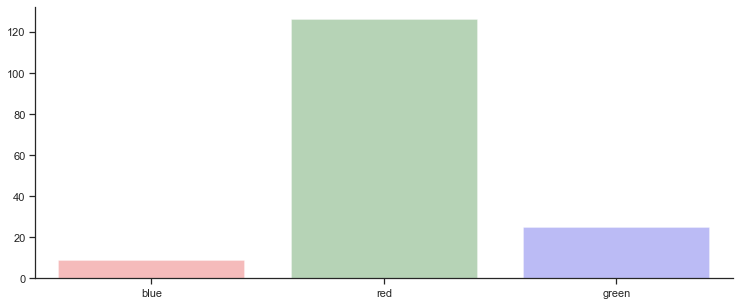

In [24]:
fig = plt.figure(figsize=(12.5, 5))
sns.set(style="ticks")
sns.barplot(x=[key for key in cnt],y=[cnt[key] for key in cnt],palette=assets,alpha=0.3)
sns.despine()